In [2]:
!pip install numpy pandas matplotlib torch keras torchmetrics lightning torchinfo torchvision
!apt-get install tree


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 24.6 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 15 not upgraded.
Need to get 47.9 kB of archives.
After this operation, 116 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tree amd64 2.0.2-1 [47.9 kB]
Fetched 47.9 kB in 1s (85.2 kB/s)
Selecting previously unselected package tree.
(Reading database ... 120899 files and directories currently installed.)
Preparing to unpack .../tree_2.0.2-1_amd64.deb ...
Unpacking tree (2.0.2-1) ...
Setting up tree (2.0.2-1) ...
Processing triggers for man-db (2.10.2-1) ...


We are working with the Sign Language MNIST dataset.
First we need to load the dataset for training and testing from the CSV files.

In [3]:
import pandas as pd

training_df = pd.read_csv("./sign_mnist_train.csv")
testing_df = pd.read_csv("./sign_mnist_test.csv")

Extract Labels and Features

In [4]:
y_train = training_df['label']
training_df.drop(['label'], axis=1, inplace=True)

y_test = testing_df['label']
testing_df.drop(['label'], axis=1, inplace=True)

In [5]:
training_df

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,107,118,127,134,139,143,146,150,153,156,...,207,207,207,207,206,206,206,204,203,202
1,155,157,156,156,156,157,156,158,158,157,...,69,149,128,87,94,163,175,103,135,149
2,187,188,188,187,187,186,187,188,187,186,...,202,201,200,199,198,199,198,195,194,195
3,211,211,212,212,211,210,211,210,210,211,...,235,234,233,231,230,226,225,222,229,163
4,164,167,170,172,176,179,180,184,185,186,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,189,189,190,190,192,193,193,193,193,194,...,132,165,99,77,52,200,234,200,222,225
27451,151,154,157,158,160,161,163,164,166,167,...,198,198,198,198,198,196,195,195,195,194
27452,174,174,174,174,174,175,175,174,173,173,...,121,196,209,208,206,204,203,202,200,200
27453,177,181,184,185,187,189,190,191,191,190,...,119,56,27,58,102,79,47,64,87,93


Define Constrants and reshape the data

In [39]:
# Model parameters
size = 28
channels = 1
batch = 128
epochs = 25

X_train = training_df.values.reshape(training_df.shape[0], size, size, channels)
X_test = testing_df.values.reshape(testing_df.shape[0], size, size, channels)

Data Augmentation and Generators

In [40]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, RandomApply, GaussianBlur, ColorJitter

# Define the transformations that are safe for the SIGN MNIST dataset
transformations = Compose([
    RandomApply([GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))], p=0.5),
    # Remove ToTensor() since the data is already in tensor form
    Normalize(mean=[0.5], std=[0.5])
])

#convert numpy array into tensors
X_train_tensor = torch.tensor(X_train.reshape(-1, size, size)).float()
y_train_tensor = torch.tensor(y_train.values).long()

X_test_tensor = torch.tensor(X_test.reshape(-1, size, size)).float()
y_test_tensor = torch.tensor(y_test.values).long()

# Apply the transformations to the training dataset
#train_dataset = [(transformations(x[None, :, :]), y) for x, y in train_dataset]
train_dataset = [(transformations(x.unsqueeze(0)), y) for x, y in zip(X_train_tensor, y_train_tensor)]

# For the validation dataset, apply only the normalization
val_transformations = Normalize(mean=[0.5], std=[0.5])

val_dataset = [(val_transformations(x.unsqueeze(0)), y) for x, y in zip(X_test_tensor, y_test_tensor)]


# Dataloaders
training_dataloader = DataLoader(train_dataset, batch_size=batch, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch, shuffle=False, num_workers=2)



Base Model

In [142]:
from typing import Tuple
from lightning.pytorch import LightningModule
from torch import nn
import torch
from torch import Tensor
import torchmetrics

class BaseModel(LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.accuracy = torchmetrics.classification.Accuracy(
            task="multiclass",
            num_classes=num_classes)
        self.model = self.build_model()

    def build_model(self):
        self.layer1 = nn.Sequential(nn.Flatten(), nn.Linear(size*size, self.num_classes))
        return self.layer1

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def forward(self, x):
        return self.model(x)

    def loss(self, logits, target):
        return nn.functional.cross_entropy(logits, target)

    def shared_step(self, mode:str, batch:Tuple[Tensor, Tensor], batch_index:int):
        x, target = batch
        output = self.forward(x)
        loss = self.loss(output, target)
        self.accuracy(output, target)
        self.log(f"{mode}_step_acc", self.accuracy, prog_bar=True)
        self.log(f"{mode}_step_loss", loss, prog_bar=False)
        return loss

    def training_step(self, batch, batch_index):
        return self.shared_step('train', batch, batch_index)

    def validation_step(self, batch, batch_index):
        return self.shared_step('val', batch, batch_index)

    def test_step(self, batch, batch_index):
        return self.shared_step('test', batch, batch_index)

Helper Functions from Assignment 2

In [143]:
import torchinfo
def describe(model, **kwargs):
    return torchinfo.summary(model,
                             input_size=(batch, 1, size, size),
                             col_names=['input_size', 'output_size', 'kernel_size', 'num_params'],
                             row_settings=['ascii_only'])

In [144]:
import shutil
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch import Trainer, seed_everything

def train(model):
    name = model.__class__.__name__
    shutil.rmtree(f'./lightning_logs/{name}', ignore_errors=True)
    seed_everything(0, workers=True)
    logger = CSVLogger('./lightning_logs', name=name)
    trainer = Trainer(max_epochs=epochs, logger=logger, deterministic=True)
    trainer.fit(model,
                train_dataloaders=training_dataloader,
                val_dataloaders=val_dataloader)

In [145]:
def show_metrics(name):
    df = pd.read_csv(f'./lightning_logs/{name}/version_0/metrics.csv')
    df.set_index('step', inplace=True)
    ax = df[['train_step_acc']].dropna().plot()
    df[['val_step_acc']].dropna().plot(ax=ax)
    return df[['val_step_acc']].dropna().round(2)

Convolution Net Model

In [193]:
class ConvNet(BaseModel):
    def __init__(self, num_classes, num_kernels, kernel_size, pool_size):
        self.num_kernels = num_kernels
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        super().__init__(num_classes)


    def build_model(self):
        return nn.Sequential(
            nn.Conv2d(1, out_channels = self.num_kernels, kernel_size = self.kernel_size, padding = 1),
            nn.AvgPool2d(kernel_size = self.pool_size),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout(p=0.4),
            nn.Linear(784, self.num_classes)
        )

In [194]:
conv_model = ConvNet(26, 4, 3, 2)
describe(conv_model)

Layer (type)                             Input Shape               Output Shape              Kernel Shape              Param #
ConvNet                                  [128, 1, 28, 28]          [128, 26]                 3                         --
+ Sequential                             [128, 1, 28, 28]          [128, 26]                 --                        --
|    + Conv2d                            [128, 1, 28, 28]          [128, 4, 28, 28]          [3, 3]                    40
|    + AvgPool2d                         [128, 4, 28, 28]          [128, 4, 14, 14]          2                         --
|    + ReLU                              [128, 4, 14, 14]          [128, 4, 14, 14]          --                        --
|    + Flatten                           [128, 4, 14, 14]          [128, 784]                --                        --
|    + Dropout                           [128, 784]                [128, 784]                --                        --
|    + Linear      

In [195]:
train(conv_model)

INFO: Seed set to 0
INFO:lightning.fabric.utilities.seed:Seed set to 0
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type               | Params
------------------------------------------------
0 | accuracy | MulticlassAccuracy | 0     
1 | model    | Sequential         | 20.4 K
------------------------------------------------
20.4 K    Trainable params
0         Non-trainable params
20.4 K

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=25` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=25` reached.


In [196]:
! tree -n ./lightning_logs/ConvNet/

./lightning_logs/ConvNet/
└── version_0
    ├── checkpoints
    │   └── epoch=24-step=5375.ckpt
    ├── hparams.yaml
    └── metrics.csv

2 directories, 3 files


,val_step_acc
step,
214,0.13
429,0.20
644,0.40
859,0.59
1074,0.68
1289,0.72
1504,0.74
1719,0.76
1934,0.78


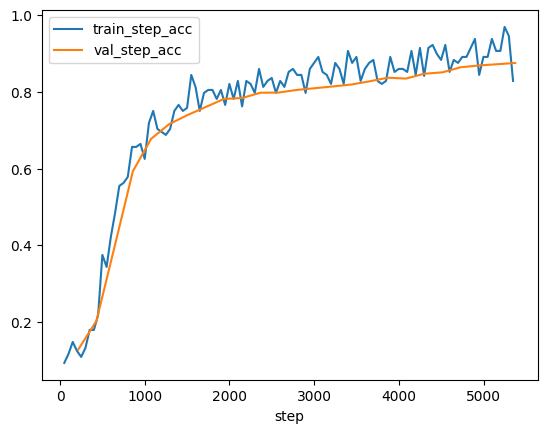

In [197]:
show_metrics('ConvNet')